# Solving an ODE with a forcing term

This example demonstrates how to incorporate an external forcing term into the solve. This is really simple: just evaluate it as part of the vector field like anything else.

This example is available as a Jupyter notebook [here](https://github.com/patrick-kidger/diffrax/blob/main/examples/forcing.ipynb).

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, ODETerm, SaveAt, Tsit5


def force(t, args):
    m, c = args
    return m * t + c


def vector_field(t, y, args):
    return -y + force(t, args)


@jax.jit
def solve(y0, args):
    term = ODETerm(vector_field)
    solver = Tsit5()
    t0 = 0
    t1 = 10
    dt0 = 0.1
    saveat = SaveAt(ts=jnp.linspace(t0, t1, 1000))
    sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=args, saveat=saveat)
    return sol


y0 = 1.0
args = (0.1, 0.02)
sol = solve(y0, args)

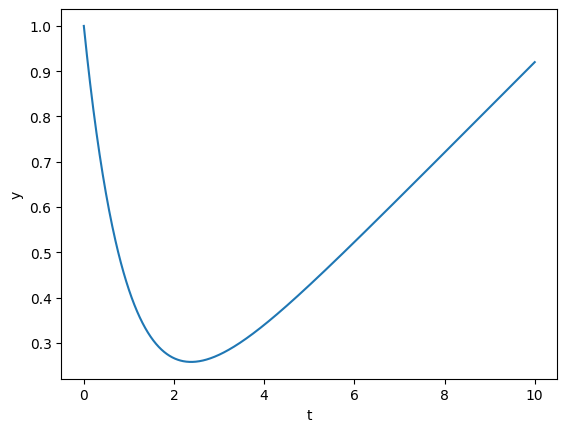

In [2]:
plt.plot(sol.ts, sol.ys)
plt.xlabel("t")
plt.ylabel("y")
plt.show()

Now let's consider a more complicated example: the forcing term is an interpolation, and what's more we would like to differentiate with respect to the values we are interpolating.

In [3]:
from diffrax import backward_hermite_coefficients, CubicInterpolation


def vector_field2(t, y, interp):
    return -y + interp.evaluate(t)


@jax.jit
@jax.grad
def solve(points):
    t0 = 0
    t1 = 10
    ts = jnp.linspace(t0, t1, len(points))
    coeffs = backward_hermite_coefficients(ts, points)
    interp = CubicInterpolation(ts, coeffs)
    term = ODETerm(vector_field2)
    solver = Tsit5()
    dt0 = 0.1
    y0 = 1.0
    sol = diffeqsolve(term, solver, t0, t1, dt0, y0, args=interp)
    (y1,) = sol.ys
    return y1


points = jnp.array([3.0, 0.5, -0.8, 1.8])
grads = solve(points)

In this example, we computed the interpolation in advance (not repeatedly on each step!), and then just evaluated it inside the vector field.